In [140]:
import sys
sys.path.append('../src')
sys.path.append('../utils')

from fbm import FBM
import numpy as np
from tqdm import notebook as tqdm
import torch

from sigKer_fast import sig_kernel
from transformers import AddTime, LeadLag

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [225]:
k = 10
L = 100

paths = []
hursts = []

for h in [0.75, 0.5, 0.25]:
    f = FBM(n=L, hurst=h, length=1.)
    for _ in range(k):
        paths.append(0.01*f.fbm())
        hursts.append(h)

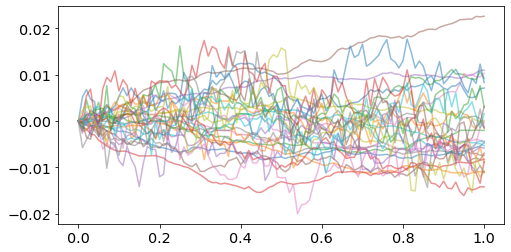

In [226]:
for p in paths:
    plt.plot(np.linspace(0,1,L+1), p, alpha=0.5)
plt.show()

In [227]:
def soft_thresholding(beta, gamma):
    alpha = np.zeros_like(beta)
    for (i,b) in enumerate(beta):
        if b>gamma:
            alpha[i] = b - gamma
        elif b<-gamma:
            alpha[i] = b + gamma
        else:
            pass
    return alpha

In [228]:
def transform(paths, at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return paths

In [229]:
N = len(paths)

In [230]:
paths = transform(paths, at=True)

In [231]:
Gram = np.zeros((N,N))

In [232]:
for i in tqdm.tqdm(range(N)):
    for j in range(N):
        Gram[i,j] = sig_kernel(paths[i], paths[j], 0)

In [233]:
def loss(beta):
    n = len(beta)
    l = 0.
    for i in range(n):
        for j in range(n):
            l += (1./n - beta[i])*(1./n - beta[j])*Gram[i,j]
    return l

In [234]:
def proximal_gradient(beta0, gamma, max_iter=100):
    losses = []
    for k in tqdm.tqdm(range(max_iter)):
        beta_temp = torch.tensor(beta0)
        beta_temp.requires_grad = True
        l = loss(beta_temp)
        l.backward()
        grad_beta = beta_temp.grad.numpy()
        beta = soft_thresholding(beta0-gamma*grad_beta, gamma)
        beta0 = beta
        losses.append(l)
    return losses, beta 

In [235]:
beta0 = 0.1*np.random.randn(N)

In [242]:
losses, beta_optimal = proximal_gradient(beta0, gamma=0.001, max_iter=100)

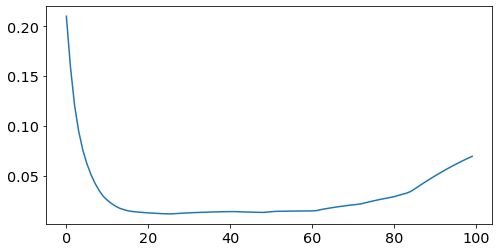

In [243]:
plt.plot(losses)
plt.show()

In [246]:
list(np.nonzero(np.abs(beta_optimal) > 0.05))

[array([ 2,  5,  8, 13, 14, 23, 26, 29], dtype=int64)]

In [247]:
beta_optimal

array([0.        , 0.        , 0.05111279, 0.        , 0.        ,
       0.11032388, 0.        , 0.        , 0.06615011, 0.        ,
       0.        , 0.01339055, 0.        , 0.0748769 , 0.07696299,
       0.        , 0.04635811, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05548271, 0.        ,
       0.        , 0.14923514, 0.        , 0.00430048, 0.17484128])